In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.models import *
from keras.layers import *
from keras.regularizers import *
import tensorflow as tf

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [0]:
def Load_Data():
  
  train_set_X = []
  train_set_Y = []
  test_set_X = []
  test_set_Y = []
  
  for i in range(1,6):
    filename = 'data_batch_'+str(i)
    dict = unpickle(filename)
    X = dict[b'data']
    Y = dict[b'labels']
    train_set_X.extend(X)
    train_set_Y.extend(Y)
    
  train_set_X = np.array(train_set_X)
  train_set_Y = np.array(train_set_Y)
  
  
  filename = 'test_batch'
  dict = unpickle(filename)
  test_set_X = np.array(dict[b'data'])
  test_set_Y = np.array(dict[b'labels'])
  
  
  filename = 'batches.meta'
  dict = unpickle(filename)
  classes = np.array(dict[b'label_names'])

  #print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape,classes.shape)
  return train_set_X,train_set_Y,test_set_X,test_set_Y,classes

In [0]:
def Reshape_And_Normalize(train_set_X,train_set_Y,test_set_X,test_set_Y):
  
  train_set_X = train_set_X.reshape(train_set_X.shape[0],3,32,32)
  train_set_X = np.moveaxis(train_set_X,1,3)
  train_set_Y = train_set_Y.reshape(1,train_set_Y.shape[0]).T
  test_set_X = test_set_X.reshape(test_set_X.shape[0],3,32,32)
  test_set_X = np.moveaxis(test_set_X,1,3)
  test_set_Y = test_set_Y.reshape(1,test_set_Y.shape[0]).T
  
  train_set_X = train_set_X
  test_set_X = test_set_X
  train_set_Y = train_set_Y
  test_set_Y = test_set_Y
  
  #print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape)
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Data_Preprocessing():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X,train_set_Y,test_set_X,test_set_Y)
  return train_set_X,train_set_Y,test_set_X,test_set_Y,classes

(50000, 1)
y = 9. It is a truck picture


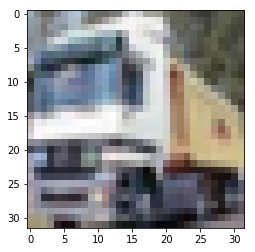

In [50]:
train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Data_Preprocessing()
#train_set_X = train_set_X.reshape(train_set_X.shape[0],3,32,32)
#train_set_X = np.moveaxis(train_set_X,1,3)
print(train_set_Y.shape)
#train_set_Y =train_set_Y.reshape(1,train_set_Y.shape[0])
i = 1
plt.imshow(train_set_X[i])
print('y = '+str(train_set_Y[i,0])+'. It is a '+classes[train_set_Y[i,0]].decode('utf-8')+' picture')

In [0]:
def Identity_Block(X,channels,f,layer,block):
  
  X_shortcut = X
  
  X = Conv2D(channels[0],kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform',name='1.Conv2D_'+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='1.BatchNorm_'+str(layer)+block)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(channels[1],kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform',name='2.Conv2D_'+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='2.BatchNorm_'+str(layer)+block)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(channels[2],kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform',name="3.Conv2D_"+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='3.BatchNorm_'+str(layer)+block)(X)
  
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def Convolutional_Block(X,channels,f,s,layer,block):
  
  X_shortcut = X
  
  X = Conv2D(channels[0],kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform',name='1.Conv2D_'+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='1.BatchNorm_'+str(layer)+block)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(channels[1],kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform',name='2.Conv2D_'+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='2.BatchNorm_'+str(layer)+block)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2,2),strides=(s,s),padding='valid',name='MaxPool2D_'+str(layer)+block)(X)
  
  X = Conv2D(channels[2],kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer='glorot_uniform',name="3.Conv2D_"+str(layer)+block)(X)
  X = BatchNormalization(axis=3,name='3.BatchNorm_'+str(layer)+block)(X)
  
  X_shortcut = Conv2D(channels[2],kernel_size=(2,2),strides=(2,2),padding='valid',kernel_initializer='glorot_uniform',name='SkipConv2D_'+str(layer)+block)(X_shortcut)
  X_shortcut = BatchNormalization(axis=3,name='SkipBatchNorm_'+str(layer)+block)(X_shortcut)
  
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def Propagation(input_shape,output_neurons):
  
  X_input = Input(input_shape)
  X = X_input
  
  X = ZeroPadding2D((3,3))(X)
  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform',name='Conv2D_1A')(X)
  X = BatchNormalization(axis=3,name='BatchNorm_1A')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='MaxPool_1A')(X)
  
  X = Convolutional_Block(X,channels=[64,64,256],f=3,s=2,layer=2,block='A')
  X = Identity_Block(X,channels=[64,64,256],f=3,layer=2,block='B')
  X = Identity_Block(X,channels=[64,64,256],f=3,layer=2,block='C')
  
  X = Convolutional_Block(X,channels=[128,128,512],f=3,s=2,layer=3,block='A')
  X = Identity_Block(X,channels=[128,128,512],f=3,layer=3,block='B')
  X = Identity_Block(X,channels=[128,128,512],f=3,layer=3,block='C')
  X = Identity_Block(X,channels=[128,128,512],f=3,layer=3,block='D')
  
  X = Convolutional_Block(X,channels=[256, 256, 1024],f=3,s=2,layer=4,block='A')
  X = Identity_Block(X,channels=[256, 256, 1024],f=3,layer=4,block='B')
  X = Identity_Block(X,channels=[256, 256, 1024],f=3,layer=4,block='C')
  X = Identity_Block(X,channels=[256, 256, 1024],f=3,layer=4,block='D')
  X = Identity_Block(X,channels=[256, 256, 1024],f=3,layer=4,block='E')
  X = Identity_Block(X,channels=[256, 256, 1024],f=3,layer=4,block='F')
  
  X = Convolutional_Block(X,channels=[512, 512, 2048],f=3,s=2,layer=5,block='A')
  X = Identity_Block(X,channels=[512, 512, 2048],f=3,layer=5,block='B')
  X = Identity_Block(X,channels=[512, 512, 2048],f=3,layer=5,block='C')
  
  #X = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='AveragePool_6A')(X)
  X = Flatten()(X)
  
  if(output_neurons > 1):
    activation = 'softmax'
  else:
    activation = 'sigmoid'

  X = Dense(output_neurons,activation=activation,kernel_initializer='glorot_uniform',bias_initializer='zeros',name='FullyConnected_6B',use_bias=True,kernel_regularizer=l2(0.01))(X)
  
  model = Model(inputs=X_input,outputs=X,name='ResNet50_Keras')
  
  return model

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Data_Preprocessing()
  epochs = 2
  mini_batch_size = 32
  output_neurons = 10
  
  if(output_neurons > 1):
    train_set_Y = np.eye(output_neurons)[train_set_Y.T][0]
    test_set_Y = np.eye(output_neurons)[test_set_Y.T][0]
    
  shape = train_set_X.shape
  shape = (shape[1],shape[2],shape[3])
  
  model = Propagation(shape,output_neurons)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(x=train_set_X[0:300,:],y=train_set_Y[0:300,:],epochs=epochs,batch_size=mini_batch_size)
  print('')
  preds = model.evaluate(x=train_set_X[0:80,:],y=train_set_Y[0:80,:])
  print("Train_Accuracy : "+str(preds[1]*100))
  print('')
  preds = model.evaluate(x=test_set_X[0:80,:],y=test_set_Y[0:80,:])
  print("Test_Accuracy : "+str(preds[1]*100))
  
  model.summary()
  print(model.predict(x=test_set_X[10:11,:]))

In [81]:
Caller_Function()

Epoch 1/2
300/300 [==============================] - 240s 800ms/step - loss: 4.8482 - acc: 0.1433
Epoch 2/2
300/300 [==============================] - 204s 679ms/step - loss: 3.9430 - acc: 0.1267

80/80 [==============================] - 8s 95ms/step
Train_Accuracy : 15.0

80/80 [==============================] - 2s 20ms/step
Test_Accuracy : 6.25
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 38, 38, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv2D_1A (Conv2D)              (None, 36, 36, 64)   1792